In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import re

IMG_SIZE = (160,160)
BATCH_SIZE = 32

### Loading the dataset:
#### Preproccesing the data and creating training/validation sets.

In [136]:
import tensorflow.keras.preprocessing as data_processing
data_dir = r"dataset"
train_data = data_processing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 128,
    image_size = IMG_SIZE,
    batch_size =  BATCH_SIZE)

Found 3834 files belonging to 2 classes.
Using 3068 files for training.


In [14]:
CLASS_NAMES = train_data.class_names
print(CLASS_NAMES)

['with_mask', 'without_mask']


### Dataset Showcase (how it looks):

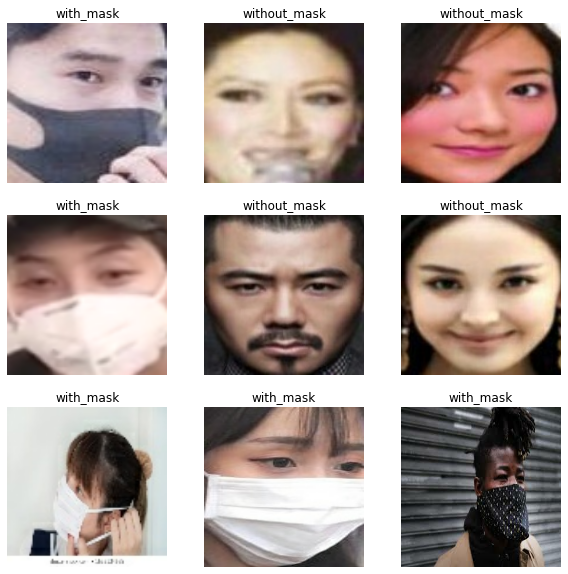

In [131]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(CLASS_NAMES[labels[i]])
    plt.axis("off")

In [138]:
unbatched_data = train_data.unbatch()

#### Creating a split of masked images and non masked images:

In [139]:
mask_images = list(image for image, label in unbatched_data.as_numpy_iterator() if CLASS_NAMES[label] == 'with_mask')
no_mask_images = list(image for image, label in unbatched_data.as_numpy_iterator() if CLASS_NAMES[label] == 'without_mask')

In [140]:
print("number of mask faces:", len(mask_images), "number of no mask faces:", len(no_mask_images))

number of mask faces: 1540 number of no mask faces: 1528


The data is pretty even, which means our dataset is balanced in regards to class distribution.

### Loading the MTCNN model
we install the package for mtcnn , then load the mtcnn model and check on each image
if the model detects a face.

In [84]:
!pip install mtcnn

You should consider upgrading via the 'python -m pip install --upgrade pip' command.



In [118]:
import mtcnn
import time
mtcnn_detector = mtcnn.MTCNN()

In [119]:
m_masked_count = 0
m_nonm_count = 0
start = time.time()

for image in mask_images:
    try:
        res = mtcnn_detector.detect_faces(image)
        if(len(res) != 0):
            m_masked_count = m_masked_count+1
    except:
        print("no face detected")

end = time.time()
total_time_mtcnn = end - start

for image in no_mask_images:
    try:
        res = mtcnn_detector.detect_faces(image)
        if(len(res) != 0):
            m_nonm_count = m_nonm_count+1
    except:
        print("no face detected")

### Loading the Haar Cascade Model (for eyes detection and face detection)

In [93]:
haarFace_path = r"Models\HaarCascade\haarcascade_frontalface_default.xml"
haarEye_path = r"Models\HaarCascade\haarcascade_eye.xml"
cascadeFace_detector = cv2.CascadeClassifier(haarFace_path)
cascadeEye_detector = cv2.CascadeClassifier(haarEye_path)

In [122]:
h_masked_count = 0
h_nonm_count = 0
start = time.time()

for image in mask_images:
    try:
        res = cascadeEye_detector.detectMultiScale(image.astype("uint8"))
        if(len(res) != 0):
            h_masked_count = h_masked_count+1
    except:
        print("no face detected")

end = time.time()
total_time_haar = end - start

for image in no_mask_images:
    try:
        res = cascadeEye_detector.detectMultiScale(image.astype("uint8"))
        if(len(res) != 0):
            h_nonm_count = h_nonm_count+1
    except:
        print("no face detected")

In [121]:
print("masked faces recognized by MTCNN: ",m_masked_count,"\nnon masked faces recognized by MTCNN: ", m_nonm_count)
print("success rate over masked: ", m_masked_count/len(mask_images) *100,"%")
print("total time for MTCNN: ", total_time_mtcnn, "seconds")

masked faces recognized by MTCNN:  1025 
non masked faces recognized by MTCNN:  1502
success rate over masked:  66.73177083333334 %
total time for MTCNN:  412.0716338157654 seconds


In [123]:
print("masked faces recognized by Haar Cascade Eye: ",h_masked_count,"\nnon masked faces recognized by Haar Cascade Eye: ", h_nonm_count)
print("success rate over masked: ", h_masked_count/len(mask_images) *100,"%")
print("total time for Haar Cascade: ", total_time_haar, "seconds")

masked faces recognized by Haar Cascade Eye:  870 
non masked faces recognized by Haar Cascade Eye:  1344
success rate over masked:  56.640625 %
total time for Haar Cascade:  11.455379962921143 seconds


### Visualize our algorithms analysis, with charts:

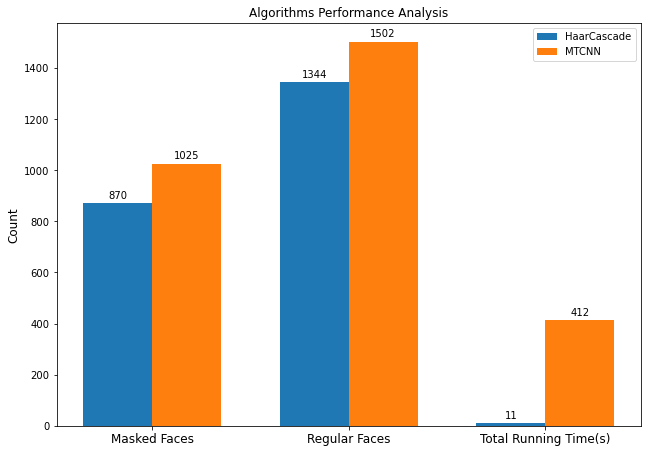

In [7]:
labels = ['Masked Faces', 'Regular Faces', 'Total Running Time(s)']
haar_data = [h_masked_count , h_nonm_count, int(total_time_haar)]
mtcnn_data = [m_masked_count,m_nonm_count , int(total_time_mtcnn)]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, haar_data, width, label='HaarCascade')
rects2 = ax.bar(x + width/2, mtcnn_data, width, label='MTCNN')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count',fontsize = 12)
ax.set_title('Algorithms Performance Analysis')
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize = 12)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
                    
autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
fig.set_size_inches(10, 7)

plt.show()

### Code for the video feed of the application, using OpenCV, and the HaarCascade Algorithm, including drawings and visualizations:

In [ ]:
cap = cv2.VideoCapture(0)
steady_eyes = False
x_face,y_face = 0,0
x_eye,y_eye = 0,0
h_eye = 500
while True:
    ret, img = cap.read()
    faces = cascadeFace_detector.detectMultiScale(img, 1.3, 5)
    eyes = cascadeEye_detector.detectMultiScale(img)
    for (x,y,w,h) in faces:
        cv2.rectangle(img, (x,y), (x+w+1, y+h+1), (255,0,0), 2)
        face = img[y-10:y+h,x:x+w]
        x_face,y_face = x,y
# if we got 2 eyes, draw them and check for steadiness
    if(len(eyes) == 2):
        if steady_eyes == False:
            start = time.time()
            steady_eyes = True

        for (xe,ye,we,he) in eyes:
            cv2.rectangle(img,(xe,ye), (xe+we, ye+he),(0,255,0),1)
            x_eye = max(x_eye,xe)
            y_eye = max(y_eye,ye)
            h_eye = min(h_eye,he)

# if the eyes detection is steady for atleast 0.5s, crop the face
        if steady_eyes == True and len(faces) > 0:
            if time.time() - start >= 0.5:
                # cropping according to some scales with face height and eyes pos/height
                cropped_face = img[y_face - int(0.08*h) :y_eye + h_eye,x_face:x_face + w]
                steady_eyes = False
                cv2.imshow('cropped',cropped_face)
    else:
        steady_eyes = False

    action = cv2.waitKey(1) & 0xff
    # cv2.imwrite('cropped_face.png',cropped_face)
    # cv2.imwrite('full_face.png',face)
    cv2.imshow('img',img)
    if action == 27: # escape button
        break
cap.release()
cv2.destroyAllWindows()

### More explanations, details, and updates soon! :)